In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import ExtendedKF, OI, EnKF

### Define functions

In [2]:
def plot_assim_result(result, X_nature, X_obs, rmse, stableidx, result_label=None):
    # plot assimilation result
    ts = np.arange(0, time, dt)
    t_obs = np.arange(0, time, obs_timeintv)

    # plot nature run and assimilation result
    fig, axs = plt.subplots(nrows=4, figsize=(20, 12))
    for i in range(3):
        axs[i].plot(ts, result[i,:], label=result_label)
        axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
        axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
    # plot RMSE and stable index
    axs[3].plot(ts, rmse, c='grey', lw=0.8)
    bool_idx = stableidx > 0
    axs[3].scatter(ts[~bool_idx], rmse[~bool_idx], s=20, c='white')
    axs[3].scatter(ts[bool_idx], rmse[bool_idx], s=20, c=stableidx[bool_idx], cmap='Reds')
    axs[3].scatter(ts[::int(obs_timeintv/dt)], rmse[::int(obs_timeintv/dt)], s=5, marker='x')

    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    axs[3].set_title('RMSE and instability')
    axs[3].set_xlabel('time')

    axs[0].legend()
    plt.tight_layout()
    return fig, axs


def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

### Create nature run

In [3]:
time = 16
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)
X_nature.shape

(3, 1600)

### Create normal observation

In [4]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [2, 2, 2] 
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.08
obs_intv = int(obs_timeintv / dt)
cycle_num = int(time / obs_timeintv)

# construct observation error
size = int(time/dt)
X_obs_err = np.zeros((3, size))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst)
    
X_obs = X_nature + X_obs_err
X_obs = X_obs[:,::obs_intv]

### Initial condition

In [5]:
X_ini = X_nature[:,[0]] + np.array([[50], [40], [60]])

### Assimilation normal observation

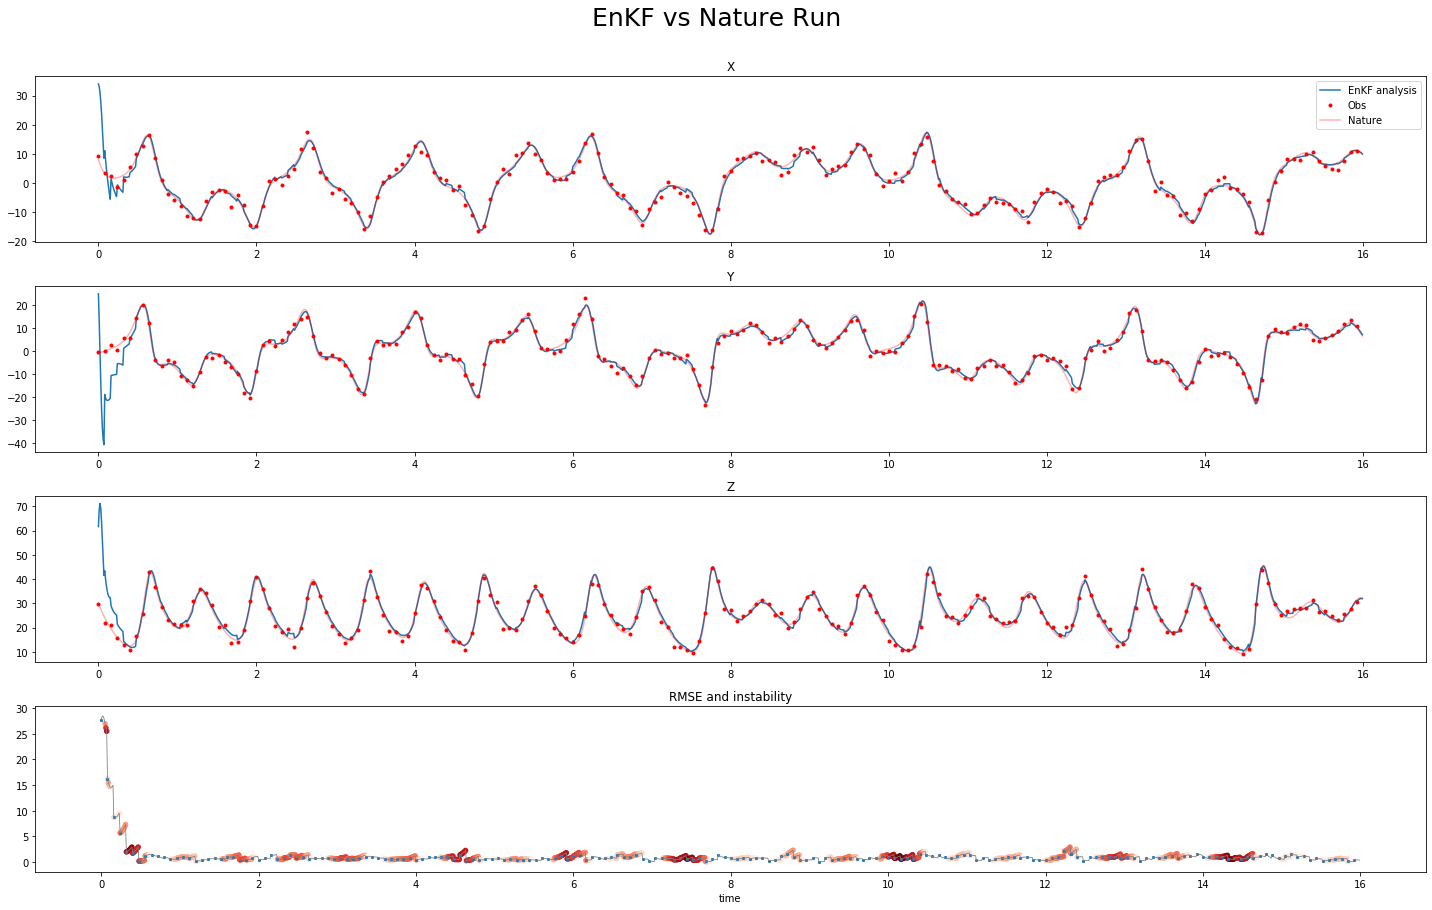

In [6]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.02

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
X_ens_ini += 55

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': X_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}

enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

# calculate RMSE and stable index
rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
stableidx = []
for x in ens_mean.T:
    stableidx.append(stability_index_lorenz63(*x))
stableidx = np.array(stableidx)

# plot
fig, axs = plot_assim_result(ens_mean, X_nature, X_obs, rmse_enkf, stableidx, 'EnKF analysis')
fig.suptitle('EnKF vs Nature Run', fontsize=25, y=1.05);

# First Moment

### create bias observation

In [7]:
ex_obs_dict = {}
ex_mean = [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for ex_m in ex_mean:
    print(ex_m)
    obs_mean = [ex_m for _ in range(3)]
    obs_var = [2, 2, 2]
    random_state = [29, 21, 36]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst+np.random.randint(0, 10))

    print(X_obs_err[:,::8].mean(axis=1))
    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_m:4.2f}'
    ex_obs_dict[key] = ex_obs

0.05
[0.08691752 0.03336505 0.0819845 ]
0.15
[-0.00872567  0.15518655  0.37176012]
0.2
[0.26775489 0.35720289 0.23691752]
0.25
[0.09127433 0.22852479 0.47176012]
0.3
[0.37845229 0.41570986 0.22351516]
0.35
[0.3362673  0.32852479 0.30601655]
0.4
[0.24127433 0.30285621 0.62176012]


In [8]:
ex_obs_dict['0.05'].shape

(3, 200)

### assimilation bias observation

obsm=0.05, Mean RMSE=1.1478, Variance RMSE=4.9019
No spinup: Mean RMSE=0.8891, Variance RMSE=0.2111
obsm=0.15, Mean RMSE=1.2168, Variance RMSE=5.1262
No spinup: Mean RMSE=0.9383, Variance RMSE=0.1473
obsm=0.20, Mean RMSE=1.1220, Variance RMSE=5.1587
No spinup: Mean RMSE=0.8318, Variance RMSE=0.1323
obsm=0.25, Mean RMSE=1.2557, Variance RMSE=4.9028
No spinup: Mean RMSE=0.9840, Variance RMSE=0.2216
obsm=0.30, Mean RMSE=1.1947, Variance RMSE=4.9731
No spinup: Mean RMSE=0.9223, Variance RMSE=0.2222
obsm=0.35, Mean RMSE=1.2012, Variance RMSE=5.2898
No spinup: Mean RMSE=0.9053, Variance RMSE=0.2066
obsm=0.40, Mean RMSE=1.2717, Variance RMSE=5.5631
No spinup: Mean RMSE=0.9537, Variance RMSE=0.2155


Text(0, 0.5, 'rmse')

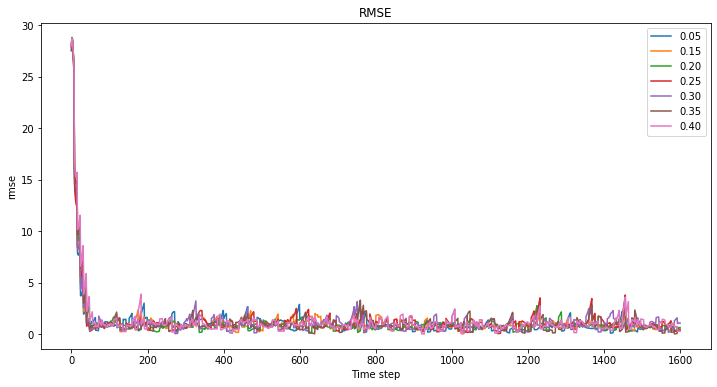

In [9]:
plt.figure(figsize=(12, 6))

for obsm in [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    key = f'{obsm:4.2f}'
    obs = ex_obs_dict[key]
    
    rng = np.random.RandomState(42)
    X_ens_ini = rng.multivariate_normal(X_nature[:,0], Pb, size=N_ens).T  # (3, N_ens)
    X_ens_ini += 55

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(f'obsm={obsm:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f}')
    print(f'No spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}')

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse')

### Create bias observation and assimilation again

In [10]:
ex_obs_dict = {}
ex_mean = np.arange(0.2, 5.2+0.25, 0.25)

for ex_m in ex_mean:
    print(ex_m)
    obs_mean = [ex_m for _ in range(3)]
    obs_var = [2, 2, 2]
    random_state = [29, 21, 36]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        X_obs_err[irow,:] = gen_random_obserr(obsm, obsv, size, obs_intv, rst+np.random.randint(0, 10))

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_m:4.2f}'
    ex_obs_dict[key] = ex_obs

0.2
0.45
0.7
0.95
1.2
1.45
1.7
1.95
2.2
2.45
2.7
2.95
3.2
3.45
3.7
3.95
4.2
4.45
4.7
4.95
5.2


obsm=0.20, Mean RMSE=1.1668, Variance RMSE=4.8115,  Without spinup: Mean RMSE=0.9202, Variance RMSE=0.2164
obsm=0.45, Mean RMSE=1.2499, Variance RMSE=5.3341,  Without spinup: Mean RMSE=0.9530, Variance RMSE=0.2067
obsm=0.70, Mean RMSE=1.3107, Variance RMSE=4.8584,  Without spinup: Mean RMSE=1.0340, Variance RMSE=0.2208
obsm=0.95, Mean RMSE=1.3823, Variance RMSE=5.2556,  Without spinup: Mean RMSE=1.1039, Variance RMSE=0.2953
obsm=1.20, Mean RMSE=1.5622, Variance RMSE=5.2926,  Without spinup: Mean RMSE=1.3099, Variance RMSE=0.4758
obsm=1.45, Mean RMSE=1.7326, Variance RMSE=5.7454,  Without spinup: Mean RMSE=1.4427, Variance RMSE=0.4613
obsm=1.70, Mean RMSE=1.8138, Variance RMSE=5.0883,  Without spinup: Mean RMSE=1.5686, Variance RMSE=0.5582
obsm=1.95, Mean RMSE=1.9793, Variance RMSE=5.5071,  Without spinup: Mean RMSE=1.7160, Variance RMSE=0.6943
obsm=2.20, Mean RMSE=2.1362, Variance RMSE=5.3823,  Without spinup: Mean RMSE=1.8906, Variance RMSE=0.6828
obsm=2.45, Mean RMSE=2.3852, Variance

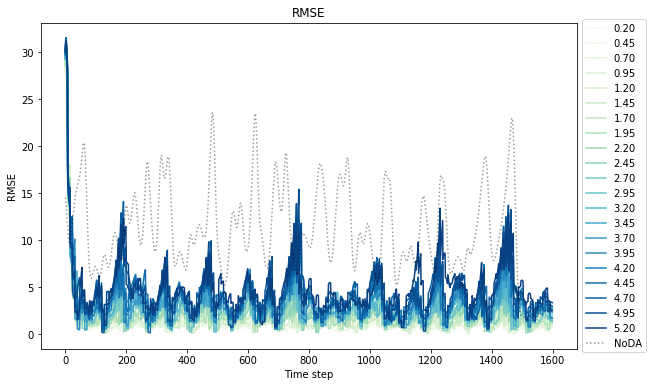

In [11]:
import matplotlib.cm as cm

colors = cm.GnBu(np.linspace(0, 1, len(ex_mean)))
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm, color in zip(ex_mean, colors):
    key = f'{obsm:4.2f}'
    obs = ex_obs_dict[key]

    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'obsm={obsm:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )
    mean_rmse.append(rmse_enkf.mean())
    mean_rmse_nospn.append(rmse_enkf[50:].mean())
    var_rmse.append(rmse_enkf.var())
    var_rmse_nospn.append(rmse_enkf[50:].var())
    
    plt.plot(rmse_enkf, label=key, color=color)
    
# no DA
X_noda_ini = X_ens_ini[:,0] - 40
ts = np.arange(0, time, dt)
forecast = lorenz63_fdm(X_noda_ini, ts)
rmse_noda = np.sqrt(np.mean((forecast-X_nature)**2, axis=0))
plt.plot(rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('RMSE');

Text(0, 0.5, 'RMSE')

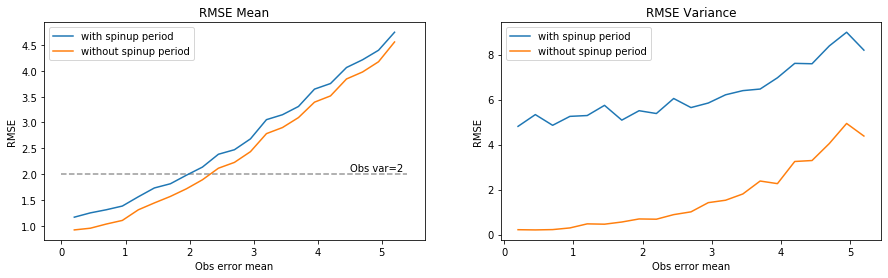

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=2, xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(4.5, 2.05, 'Obs var=2')

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE')

# Third Moment

### create skew observatoin

In [13]:
from scipy.stats import skewnorm


def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [14]:
ex_obs_dict = {}
ex_alpha = [0.15, 0.45, 0.75, 1.05, 1.35]

for ex_a in ex_alpha:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

### assimilation skew observation

alpha=0.15, Mean RMSE=1.1370, Variance RMSE=4.9195,  Without spinup: Mean RMSE=0.8797, Variance RMSE=0.1738
alpha=0.45, Mean RMSE=1.1262, Variance RMSE=5.2029,  Without spinup: Mean RMSE=0.8474, Variance RMSE=0.1611
alpha=0.75, Mean RMSE=1.1807, Variance RMSE=5.0677,  Without spinup: Mean RMSE=0.9032, Variance RMSE=0.1637
alpha=1.05, Mean RMSE=1.1309, Variance RMSE=5.1307,  Without spinup: Mean RMSE=0.8445, Variance RMSE=0.1264
alpha=1.35, Mean RMSE=1.2707, Variance RMSE=5.3196,  Without spinup: Mean RMSE=0.9806, Variance RMSE=0.2138


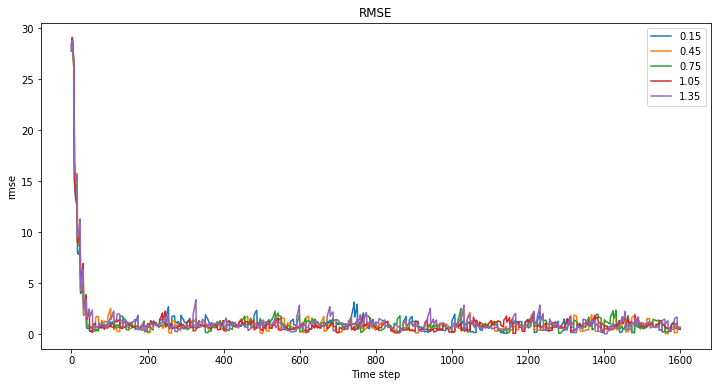

In [15]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

### test which skewness value would be rejected in the Shapiro test with 200 samples

In [16]:
from scipy.stats import shapiro, jarque_bera

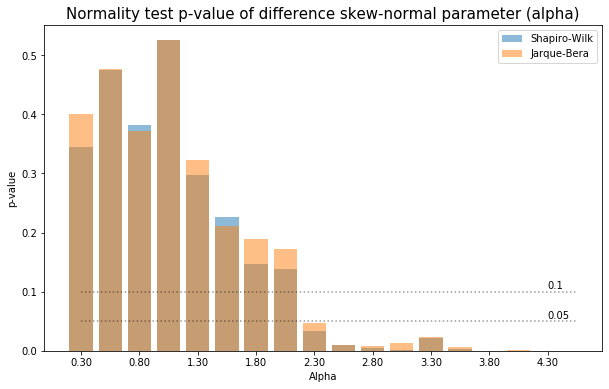

In [17]:
alphas = np.arange(0.3, 4.3+0.25, 0.25)
N = 10

shapiro_p = np.zeros((N, len(alphas)))
jarque_p = np.zeros_like(shapiro_p)

for i in range(N):
    for j, alpha in enumerate(alphas):
        samples = gen_skewnormal(0, 2, alpha, 200)
        sp = shapiro(samples)[1]
        jp = jarque_bera(samples)[1]
        shapiro_p[i,j] = sp
        jarque_p[i,j] = jp
    
shapiro_p = shapiro_p.mean(axis=0)
jarque_p = jarque_p.mean(axis=0)

plt.figure(figsize=(10, 6))
x = list(range(len(alphas)))
plt.bar(x, shapiro_p, alpha=0.5, label='Shapiro-Wilk')
plt.bar(x, jarque_p, alpha=0.5, label='Jarque-Bera')
plt.legend()

xticklabels = [f'{a:4.2f}' for a in alphas]
plt.xticks(x[::2], xticklabels[::2])
plt.hlines([0.1, 0.05], xmin=0, xmax=len(alphas), ls='dotted', alpha=0.4)
plt.text(len(alphas)-1, 0.105, '0.1')
plt.text(len(alphas)-1, 0.055, '0.05')
plt.xlabel('Alpha')
plt.ylabel('p-value')
plt.title('Normality test p-value of difference skew-normal parameter (alpha)', fontsize=15);

### create skew observation and assimilation again

In [18]:
ex_obs_dict = {}

for ex_a in ex_alpha:
    obs_mean = [0, 0, 0]
    obs_var = [2, 2, 2]
    
    obs_timeintv = 0.08
    obs_intv = int(obs_timeintv / dt)
    cycle_num = int(time / obs_timeintv)
    
    size = int(time/dt)
    X_obs_err = np.zeros((3, size))
    for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
        # generate observations
        skew_obs = gen_skewnormal(obsm, obsv, ex_a, size)
        
        # set observations as 0 if it is not at the time of assimilation
        skew_obs_c = skew_obs.copy()
        skew_obs_c[::obs_intv] = 0
        skew_obs = skew_obs - skew_obs_c
        X_obs_err[irow,:] = skew_obs

    ex_obs = X_nature + X_obs_err
    ex_obs = ex_obs[:,::obs_intv]
    
    key = f'{ex_a:4.2f}'
    ex_obs_dict[key] = ex_obs

alpha=0.15, Mean RMSE=1.2138, Variance RMSE=5.7310,  Without spinup: Mean RMSE=0.9045, Variance RMSE=0.2040
alpha=0.45, Mean RMSE=1.1293, Variance RMSE=4.8656,  Without spinup: Mean RMSE=0.8831, Variance RMSE=0.1810
alpha=0.75, Mean RMSE=1.1709, Variance RMSE=5.3291,  Without spinup: Mean RMSE=0.8877, Variance RMSE=0.1850
alpha=1.05, Mean RMSE=1.1211, Variance RMSE=5.0096,  Without spinup: Mean RMSE=0.8495, Variance RMSE=0.1691
alpha=1.35, Mean RMSE=1.1233, Variance RMSE=4.6236,  Without spinup: Mean RMSE=0.8786, Variance RMSE=0.1586


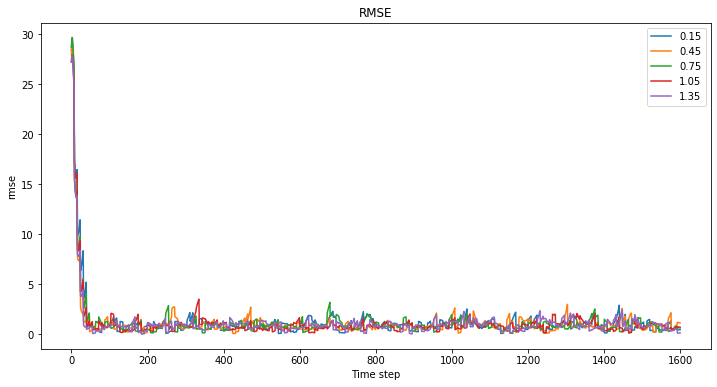

In [19]:
plt.figure(figsize=(12, 6))

for ex_a in ex_alpha:
    key = f'{ex_a:4.2f}'
    obs = ex_obs_dict[key]
    
    enkf_params = {
        'X_ens_ini': X_ens_ini, 
        'obs': obs, 
        'obs_interv': 8, 
        'R': R, 
        'H_func': None, 
        'alpha': 0.3,
        'inflat': 1.4
    }

    enkf = EnKF(lorenz63_fdm, dt)
    enkf.set_params(**enkf_params)
    enkf.cycle()
    enkf.analysis
    ens_mean = enkf.analysis.mean(axis=0)

    # calculate RMSE and stable index
    rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
    print(
        f'alpha={ex_a:.2f}, Mean RMSE={rmse_enkf.mean():.4f}, Variance RMSE={rmse_enkf.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse_enkf[50:].mean():.4f}, Variance RMSE={rmse_enkf[50:].var():.4f}'
    )

    plt.plot(rmse_enkf, label=key)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse');

### check if sample skewness is close to theory skew value

In [20]:
from scipy.stats import skew

for ex_a in ex_alpha:
    key = f'{ex_a:.2f}'
    print('Alpha = ', key, ':')
    obs = ex_obs_dict[key]
    
    obs_err = np.zeros_like(obs)
    for irow in range(obs_err.shape[0]):
        obs_err[irow,:] = obs[irow,:] - X_nature[irow,::obs_intv]
    
    theory_skew = tskew(ex_a)
    sample_skew = [skew(obs_err[irow,:]) for irow in range(obs_err.shape[0])]
    
    print(f'Theory Skew: {theory_skew:.4f}')
    print('Sample Skew:', f'{sample_skew[0]:.4f}, {sample_skew[1]:.4f}, {sample_skew[2]:.4f}')
    print()

Alpha =  0.15 :
Theory Skew: 0.0007
Sample Skew: 0.0471, 0.0723, -0.0774

Alpha =  0.45 :
Theory Skew: 0.0179
Sample Skew: 0.0155, 0.1681, -0.5007

Alpha =  0.75 :
Theory Skew: 0.0696
Sample Skew: 0.0850, 0.3301, 0.1036

Alpha =  1.05 :
Theory Skew: 0.1523
Sample Skew: 0.3168, 0.6565, 0.0538

Alpha =  1.35 :
Theory Skew: 0.2503
Sample Skew: 0.1348, 0.4311, 0.3584



### use rainfall data and find its skewness

In [21]:
rain = np.load('rain.npy')  # (ensemble, time, lat, lon)
# use ensemble mean
rain = rain.mean(axis=0)
# only use the middle period
rain = rain[50:60,:,:].mean(axis=0)
rain.shape

FileNotFoundError: [Errno 2] No such file or directory: 'rain.npy'

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
ax.hist(rain.ravel(), alpha=0.5)
ax.set_title('Rainfall distribution')
ax.text(6, 10000, f'skew={skew(rain.ravel()):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(rain.ravel(), lw=2, color='#764645', ax=ax2);

In [ ]:
# check the distribution without no rainfall grids
rain_no0 = rain.ravel()[rain.ravel() != 0]

fig, ax = plt.subplots()
ax.hist(rain_no0.ravel(), alpha=0.5)
ax.set_title('Rainfall distribution (Without no rainfall grid)')
ax.text(6, 10000, f'skew={skew(rain_no0.ravel()):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(rain_no0.ravel(), lw=2, color='#764645', ax=ax2);

In [ ]:
tskew(100000)

In [ ]:
# Theory max skewness of skewnorm distribution
(4-np.pi) / (np.pi-2) * np.sqrt(2 / (np.pi-2))

In [ ]:
# check the distribution without no rainfall grids
normalize_rain = (rain.ravel() - rain.mean()) / np.sqrt(rain.var())

fig, ax = plt.subplots()
ax.hist(normalize_rain, alpha=0.5)
ax.set_title('Normalize rainfall distribution')
ax.text(4, 10000, f'skew={skew(normalize_rain):.4f}', fontsize=13)

ax2 = ax.twinx()
sns.kdeplot(normalize_rain, lw=2, color='#764645', ax=ax2);

### Use normalize rainfall distribution as the observation error distribution, and assimilate it

In [ ]:
# adjust to var=2
nrain_var2 = normalize_rain * np.sqrt(2)
print('Statistics of this fake population:')
print(f'Mean = {nrain_var2.mean():.3f}')
print(f'Var  = {nrain_var2.var():.3f}')
print(f'Skew = {skew(nrain_var2):.3f}')

# sample
ndim, obs_size = X_obs.shape
nrain_obserr = np.zeros((ndim, X_nature.shape[1]))
for i in range(ndim):
    nrain_obserr[i,:] = np.random.choice(nrain_var2, size=X_nature.shape[1])

tmp = nrain_obserr.copy()
tmp[:,::obs_intv] = 0
nrain_obserr -= tmp

nrain_obs = X_nature + nrain_obserr
nrain_obs = nrain_obs[:,::obs_intv]

# plot the distribution of nrain_obserr
fig, axs = plt.subplots(ncols=ndim, figsize=(15, 4))
for i, ax in enumerate(axs):
    ax.hist(nrain_obserr[i,::obs_intv])
    text = (
        'Sample Statistics:\n'
        f'Size   = {size}\n'
        f'Mean = {nrain_obserr[i,::obs_intv].mean():.3f}\n'
        f'Var    = {nrain_obserr[i,::obs_intv].var():.3f}\n'
        f'Skew = {skew(nrain_obserr[i,::obs_intv]):.3f}'
    )
    ax.text(1, 60, text, fontsize=15)
    ax.set_title(chr(ord('X')+i))

In [ ]:
plt.figure(figsize=(12, 6))

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs': nrain_obs, 
    'obs_interv': 8, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}
enkf = EnKF(lorenz63_fdm, dt)
enkf.set_params(**enkf_params)
enkf.cycle()
enkf.analysis
ens_mean = enkf.analysis.mean(axis=0)

rmse_enkf = np.sqrt(np.mean((ens_mean-X_nature)**2, axis=0))
plt.plot(rmse_enkf)
plt.title('RMSE')
plt.xlabel('Time step')
plt.ylabel('rmse')

print(rmse_enkf.mean())

In [ ]:
rmse_enkf.mean()

In [ ]:
# check the ratio of this rainfall observation error that exceed to 2*std

within = (np.abs(nrain_obserr[:,::obs_intv]) <= 2*np.sqrt(np.array(obs_var)[:,np.newaxis])).sum(axis=1)
total = nrain_obserr[:,::obs_intv].shape[1]
ratio = within / total

plt.bar([0, 1, 2], total, edgecolor='k', color='white')
plt.bar([0, 1, 2], within, edgecolor='k')
for i in range(3):
    plt.text(i-0.1, within[i]-10, str(ratio[i]))
plt.xticks([0, 1, 2], ['X', 'Y', 'Z']);

In [ ]:
## 看看前面同化降雨分布的實驗裡，RMSE的上升有多少是因為不穩定，又有多少是因為skew的outlier

# Fourth Moment